In [53]:
from enum import Enum
from dataclasses import dataclass
import random

# Visualize schedule
To debug and compare the results to the solution found in https://developers.google.com/optimization/scheduling/job_shop#a_solution_for_the_problem, we create a Gantt chart.

In [54]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

def plot_schedule(data):
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = colormaps.get_cmap('tab20')
    for m_idx, machine_tasks in enumerate(data):
        for task in machine_tasks:
            ax.broken_barh([(task.offset, task.duration)], (m_idx - 0.4, 0.8), 
                            facecolors=cmap(task.job_index % 20), edgecolor='black', linewidth=1) 
            ax.text(task.offset + task.duration/2, m_idx, f'J{task.job_index}({task.task_index})', 
                    ha='center', va='center', color='black', fontsize=9) 

    ax.set_xlabel('Time Units')
    ax.set_ylabel('Machine Index')
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels([f'Machine {i}' for i in range(len(data))]
)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    plt.title('Job Shop Schedule Visualization')
    plt.tight_layout()
    plt.show()

# Parse input file to extract job information

In [55]:
def parse_instance(file_name, instance_name):
    with open(file_name,'r') as f:
        lines=f.readlines()
    start_idx=-1
    for i,line in enumerate(lines):
       if f"instance {instance_name}" in line.strip():
           start_idx=i
           break
    if start_idx == -1:
        raise ValueError(f"Instance {instance_name} not found in file {file_name}.")
    skip_line=start_idx+4
    num_jobs,num_machines=map(int, lines[skip_line].split())
    jobs_data=[]
    for i in range(1, num_jobs+1):
        line_content=lines[skip_line+i].strip().split()
        job_data_copy=[]
        for j in range(0, len(line_content),2):
            machine=int(line_content[j])
            time=int(line_content[j+1])
            job_data_copy.append((machine,time))
        jobs_data.append(job_data_copy)
    return num_machines, num_jobs, jobs_data

# Classes to make the code more readable

In [56]:
class Strategy(Enum):
    PLUS = 1
    COMMA = 2

@dataclass
class Task:
    machine_index: int
    job_index: int
    task_index: int
    duration: int
    offset: int

class Candidate:
    def __init__(self, schedule: list[list[Task]]) -> None:
        self.schedule = schedule
        self.time = max(machine[-1].duration + machine[-1].offset for machine in schedule)

    def __repr__(self) -> str:
        return f"{self.time} {[[(task.job_index, task.task_index, task.duration, task.offset) for task in machine] for machine in self.schedule]}"

# Create candidate solutions by populating schedule
Randomly select an active job and schedule it on the required machine. If no job can be scheduled since the previous jobs are not yet completed, we wait for a random job instead and then schedule it.

In [57]:
def create_candidate(schedule, machine_ready_times, task_ready_times, next_task_by_job, active_jobs, data) -> Candidate:
    # populate schedule for each machine
    while active_jobs:
        selected_job = random.choice(active_jobs)
        selected_task = next_task_by_job[selected_job]

        # queue task for required machine
        machine, duration = data[selected_job][selected_task]
        offset = max(task_ready_times[selected_job], machine_ready_times[machine])
        #print(selected_job, selected_task, "->", machine, duration, ": starts at", offset, "ends at", offset + duration)
        task_info = Task(machine, selected_job, selected_task, duration, offset)
        schedule[machine].append(task_info)

        task_ready_times[selected_job] = duration + offset
        machine_ready_times[machine] += duration

        # check if this was the last task for this job
        next_task_by_job[selected_job] += 1
        if next_task_by_job[selected_job] >= len(data[selected_job]):
            active_jobs.remove(selected_job)
    
    return Candidate(schedule)

# Set up the variables for the initial candidates
To create new candidates, we need to initialize all variables to default values.

In [58]:
def get_initial_candidates(m, num_machines, num_jobs, data):
    candidates = list[Candidate]()
    for _ in range(m):
        # create a schedule for each machine
        schedule = [list[Task]() for _ in range(num_machines)]
        # for each machine, store when it becomes available again
        machine_ready_times = [0] * num_machines
        task_ready_times = [0] * num_jobs
        # for each job, store the index of the next task to schedule
        next_task_by_job = [0] * len(data)
        # jobs that still have tasks left
        active_jobs = [job_index for job_index, _ in enumerate(data)]
        candidate = create_candidate(schedule, machine_ready_times, task_ready_times, next_task_by_job, active_jobs, data)
        candidates.append(candidate)
    return candidates

# Mutate parents to create children/ offsprings
We expect $l / len(parents)$ to be an integer so that the correct number of children are created.
For the mutation algorithm, we randomly select a job and cut off all jobs that appear after the start time of the selected job. We then re-populate the schedule from that point on by again randomly selecting active jobs.

In [59]:
def mutate(parents: list[Candidate], l, num_machines, num_jobs, data) -> list[Candidate]:
    children_per_parent = l / len(parents)
    children = list[Candidate]()
    for parent in parents:
        for _ in range(int(children_per_parent)):
            # select random task to split at
            jobs = len(parent.schedule)
            tasks = len(parent.schedule[0])
            random_job = random.randint(0, jobs - 1)
            random_task = random.randint(0, tasks - 1)
            chosen_task = parent.schedule[random_job][random_task]
            schedule = [list[Task]() for _ in range(num_machines)]
            
            # copy parent schedule to child
            for i in range(jobs):
                for j in range(tasks):
                    if parent.schedule[i][j].offset <= chosen_task.offset:
                        schedule[i].append(parent.schedule[i][j])
            
            # reconstruct state from the partial schedule
            machine_ready_times = [0] * num_machines
            task_ready_times = [0] * num_jobs
            next_task_by_job = [0] * num_jobs
            
            # scan through copied tasks to rebuild state
            for i, machine_tasks in enumerate(schedule):
                if machine_tasks:
                    last_task = machine_tasks[-1]
                    machine_ready_times[i] = last_task.offset + last_task.duration
                
            # find the highest task_index for each job
            for job_index in range(num_jobs):
                max_task_index = -1
                for machine_tasks in schedule:
                    for task in machine_tasks:
                        if task.job_index == job_index and task.task_index > max_task_index:
                            max_task_index = task.task_index
                            task_ready_times[job_index] = task.offset + task.duration
                next_task_by_job[job_index] = max_task_index + 1
            
            # only jobs with remaining tasks are active
            active_jobs = [job_index for job_index in range(num_jobs) if next_task_by_job[job_index] < len(data[job_index])]
            
            candidate = create_candidate(schedule, machine_ready_times, task_ready_times, next_task_by_job, active_jobs, data)
            children.append(candidate)
    return children

# Population strategies
Here, we solve the problem by iterating over all generations and create new offsprings and select the next generation depending on the strategy.

In [60]:
def solve(strategy: Strategy, m, l, max_generations, num_machines, num_jobs, data) -> Candidate:
    parents = get_initial_candidates(m, num_machines, num_jobs, data)
    offsprings = list[Candidate]()
    for _ in range(max_generations):
        offsprings = mutate(parents, l, num_machines, num_jobs, data)
        if strategy == Strategy.PLUS:
            offsprings.extend(parents)
            offsprings.sort(key=lambda x: x.time) 
            parents = []
            for i in range(m):
                parents.append(offsprings[i])
        elif strategy == Strategy.COMMA:
            offsprings.sort(key=lambda x: x.time) 
            parents = []
            for i in range(m):
                parents.append(offsprings[i])
    parents.sort(key=lambda x: x.time) 
    return parents[0]

818 [[(13, 1, 41, 52), (7, 0, 32, 41), (12, 0, 10, 73), (16, 0, 13, 83), (6, 0, 27, 96), (19, 2, 43, 143), (0, 2, 21, 191), (5, 8, 24, 211), (1, 4, 40, 331), (10, 3, 42, 251), (8, 4, 20, 293), (3, 6, 34, 330), (17, 11, 48, 425), (18, 4, 27, 395), (2, 6, 19, 422), (11, 12, 15, 546), (14, 12, 38, 556), (15, 17, 48, 585), (9, 16, 47, 640), (4, 18, 21, 749)], [(5, 2, 18, 50), (2, 1, 12, 71), (16, 4, 36, 230), (9, 4, 22, 266), (15, 8, 22, 347), (12, 6, 28, 270), (1, 7, 20, 446), (11, 8, 26, 426), (13, 11, 31, 515), (10, 8, 45, 428), (3, 13, 48, 515), (7, 12, 33, 475), (17, 17, 38, 654), (8, 9, 32, 537), (0, 10, 31, 483), (14, 14, 29, 610), (4, 11, 46, 539), (19, 16, 42, 695), (6, 14, 17, 660), (18, 17, 40, 777)], [(11, 3, 28, 131), (15, 3, 37, 197), (13, 5, 43, 334), (12, 5, 49, 221), (17, 14, 32, 557), (3, 10, 48, 438), (1, 13, 19, 592), (8, 8, 47, 490), (14, 10, 35, 478), (5, 16, 24, 476), (18, 11, 18, 650), (10, 11, 13, 541), (19, 14, 28, 632), (7, 18, 15, 651), (9, 15, 19, 621), (6, 11,

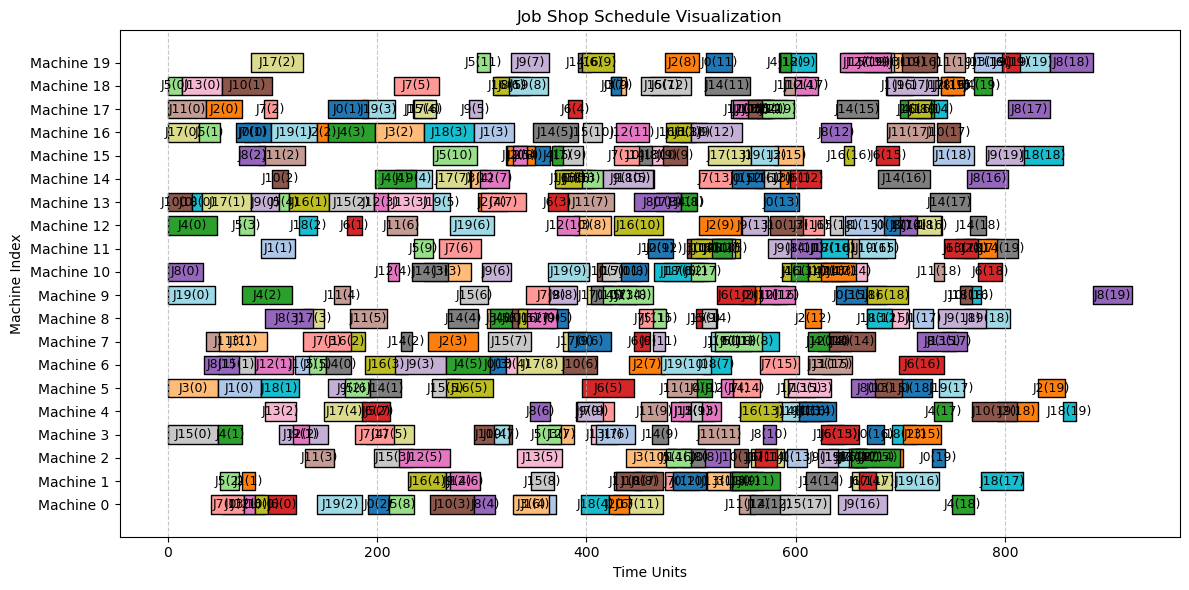

In [62]:
m = 5
l = 15
max_gens = 100

num_machines, num_jobs, data = parse_instance("jobshop_hackathon_instance.txt", "a")
candidate = solve(Strategy.PLUS, m, l, max_gens, num_machines, num_jobs, data)
print(candidate)
plot_schedule(candidate.schedule)